### Image Source
[1] https://www.programmersought.com/article/17576123317  
[2] http://winspection.com/surface-inspection.php

### Python import

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches, text, patheffects
from tqdm import tqdm
from glob import glob

import torch
from module.label_map import get_label_map
from module.config import config_from_yaml
from module.model import MASK_MODEL, CLF_MODEL
from module.helper import get_batch_file_list, get_ts
from module.predict import batch_prediction_tta

CFG = config_from_yaml('config.yaml')

### Load Model

In [2]:
mask_model = MASK_MODEL(num_channel = CFG.DATA.N_CHANNEL, 
                        num_class   = CFG.DATA.N_CLASS,
                        min_size    = CFG.TRAIN.IMG_SIZE, 
                        max_size    = CFG.TRAIN.IMG_SIZE, 
                        image_mean  = CFG.DATA.N_CHANNEL * [CFG.TRAIN.IMG_MEAN],
                        image_std   = CFG.DATA.N_CHANNEL * [CFG.TRAIN.IMG_STD],
                        pretrained  = CFG.TRAIN.MASK.PRETRAINED)
mask_model.load_state_dict(torch.load(CFG.TEST.MASK_WEIGHT, map_location=CFG.TEST.DEVICE))
mask_model.to(CFG.TEST.DEVICE)
mask_model.eval()

clf_model = CLF_MODEL(name        = CFG.TRAIN.CLF.NAME,
                      num_channel = CFG.DATA.N_CHANNEL, 
                      num_class   = CFG.DATA.N_CLASS,
                      image_mean  = CFG.DATA.N_CHANNEL * [CFG.TRAIN.IMG_MEAN],
                      image_std   = CFG.DATA.N_CHANNEL * [CFG.TRAIN.IMG_STD],
                      smoothing   = CFG.TRAIN.CLF.SMOOTHING,
                      pretrained  = CFG.TRAIN.CLF.PRETRAINED)
clf_model.load_state_dict(torch.load(CFG.TEST.CLF_WEIGHT, map_location=CFG.TEST.DEVICE))
clf_model.to(CFG.TEST.DEVICE)
clf_model.eval()

print('Model Loaded')

Model Loaded


### Inference

In [3]:
def plot_graph(images, preds, index=0, thr=0.25, figsize=(10, 10)):
    image  = images[index][:, :, 0]
    scores = preds[index]['t_scores']
    labels = preds[index]['labels']
    names  = np.array([get_label_map()[label] for label in labels])
    boxes  = preds[index]['boxes']
    mask   = preds[index]['masks']
    mask   = np.where(mask > 0, mask, np.nan)
    mask[0, 0] = 1e-7

    # Plot
    fig, ax = plt.subplots(1, 3, figsize=figsize)

    # Draw Image
    ax[0].imshow(image, cmap='gray')
    ax[1].imshow(image, cmap='gray')
    ax[1].imshow(mask, alpha=0.5, cmap='Reds')
    ax[2].imshow(mask, alpha=0.8, cmap='Reds')
    
    ax[0].set_xlabel('Original Image', fontsize=13)
    ax[1].set_xlabel('Prediction', fontsize=13)
    ax[2].set_xlabel('Defect Map', fontsize=13)
    
    if len(labels) == 0:
        ax[2].imshow(image*0, cmap='Reds')

    else:
        # Select Data over thr
        select = np.where(scores > thr)
        if len(select[0]) == 0:
            select = (np.array([0]))
        scores = scores[select]
        labels = labels[select]
        names  = names[select]
        boxes  = boxes[select]

        # Get Info
        n_obj  = len(scores)
        img_size, _ = image.shape
        for i in range(n_obj):
            # Draw Bbox
            x_min, y_min, x_max, y_max = boxes[i]
            ax[1].add_patch(patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min,
                                           fill=False, edgecolor='orange', lw=3))

            # Write Name
            ax[1].text(x_min, y_min-8*img_size/100, 
                    f'{names[i]} ({int(scores[i]*100)}%)', fontsize=15, weight='bold', verticalalignment='top', color='orange'
                   ).set_path_effects([patheffects.Stroke(linewidth=3, foreground='red'), patheffects.Normal()])
            
    ax[0].xaxis.set_ticks([])
    ax[0].yaxis.set_visible(False)
    ax[1].xaxis.set_ticks([])
    ax[1].yaxis.set_visible(False)
    ax[2].xaxis.set_ticks([])
    ax[2].yaxis.set_visible(False)
    plt.show()

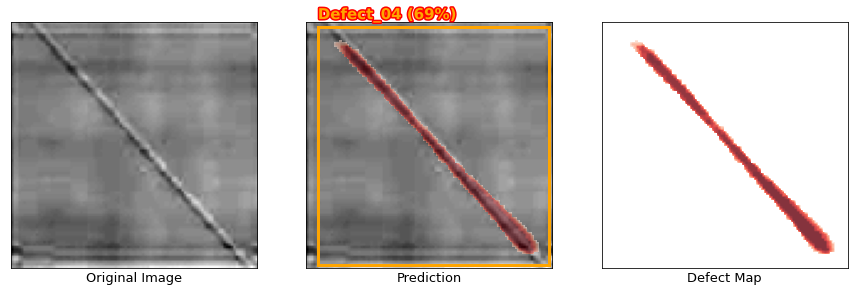

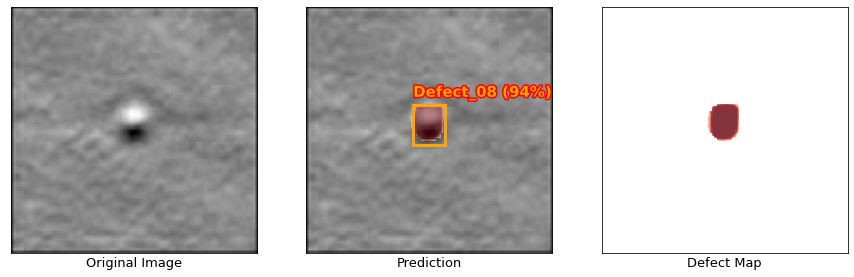

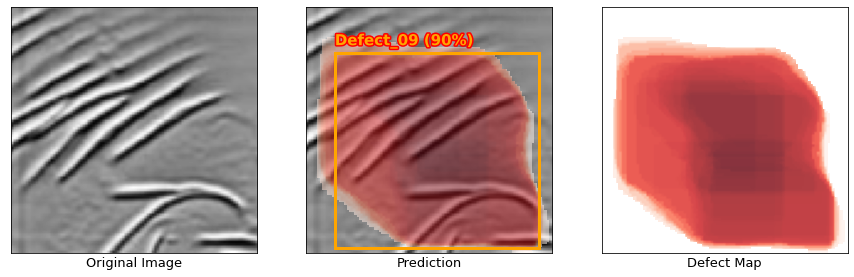

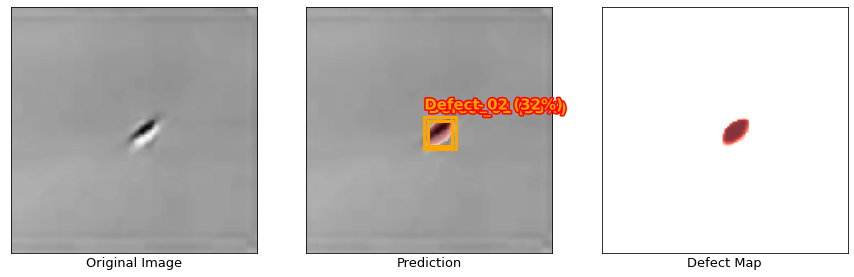

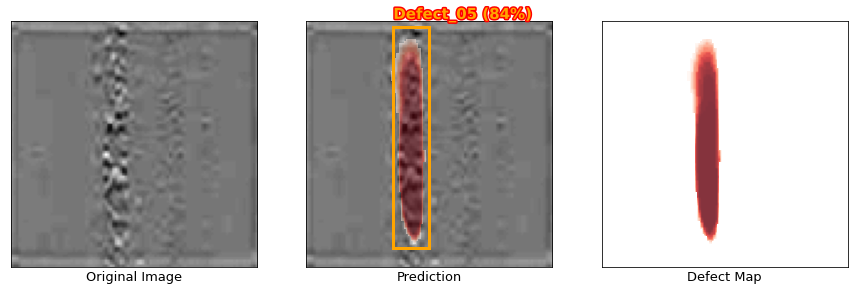

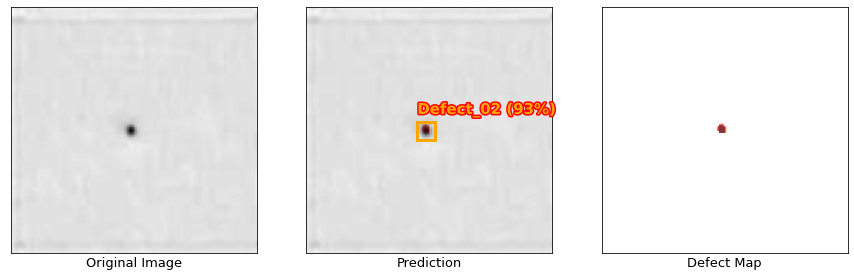

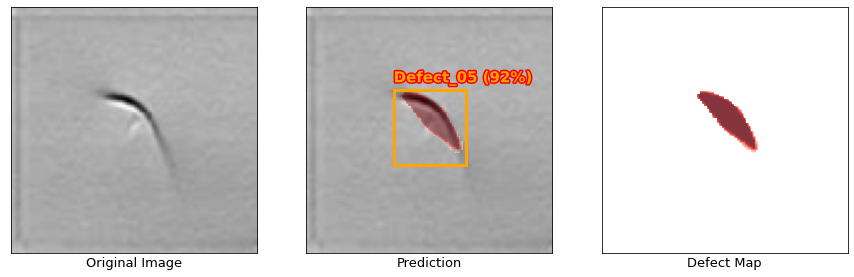

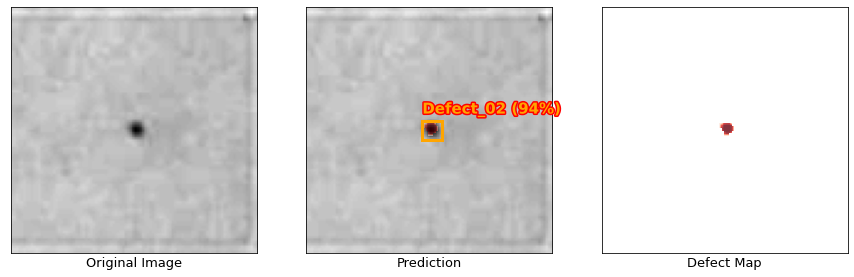

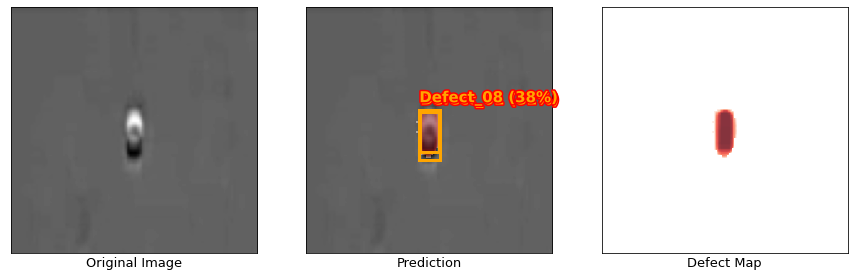

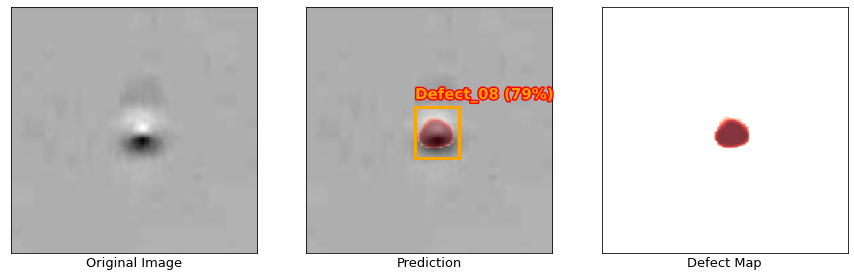

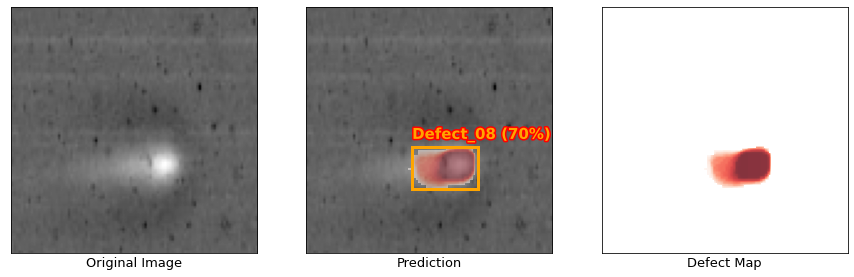

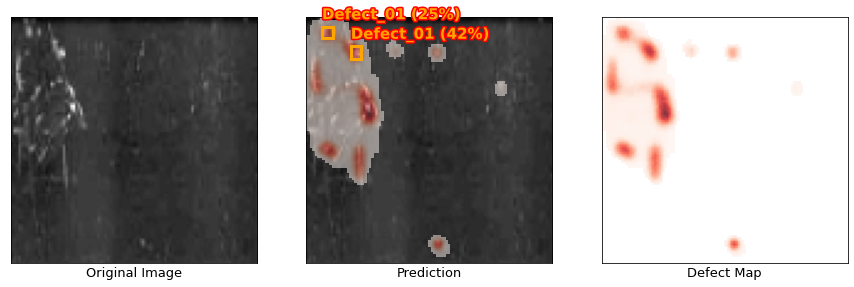

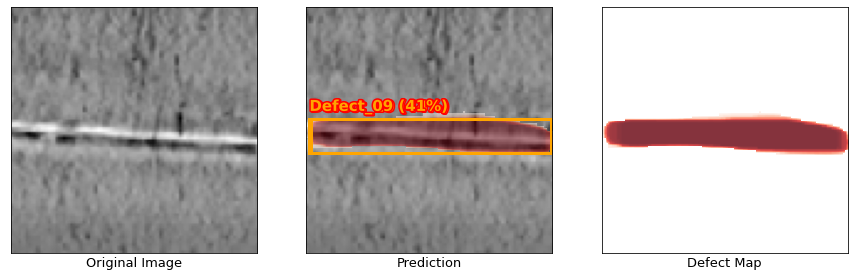

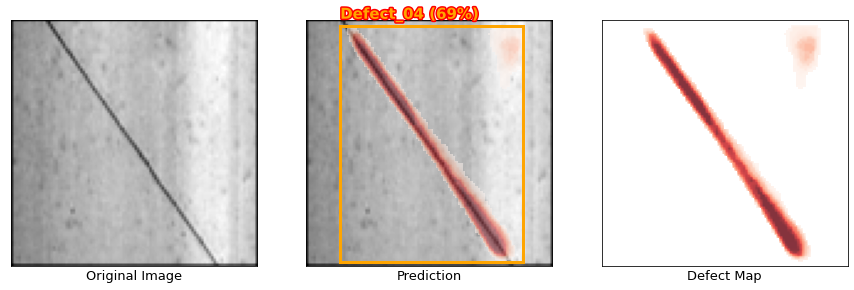

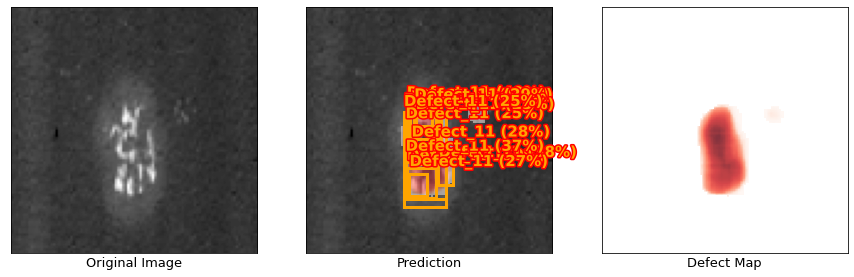

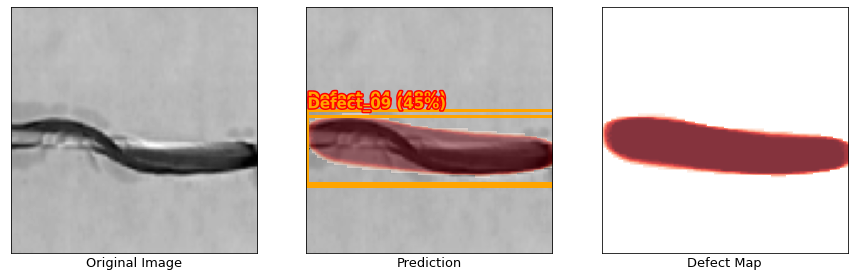

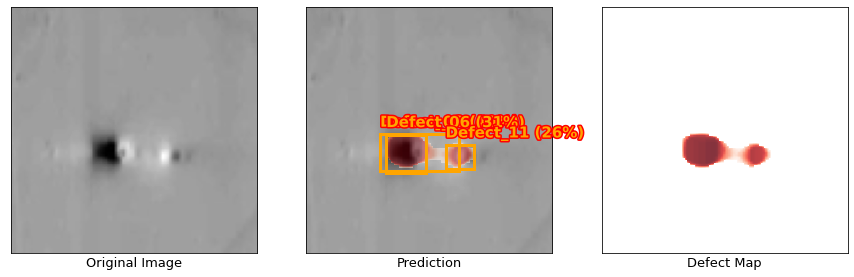

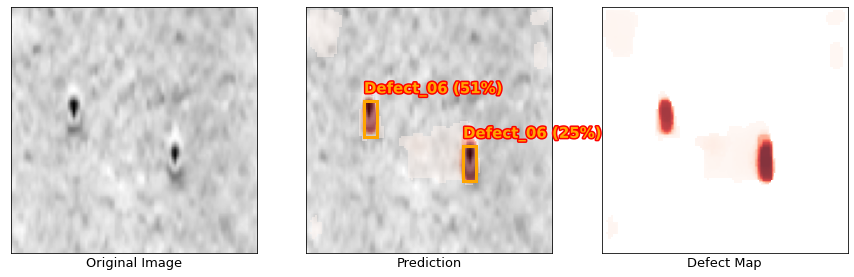

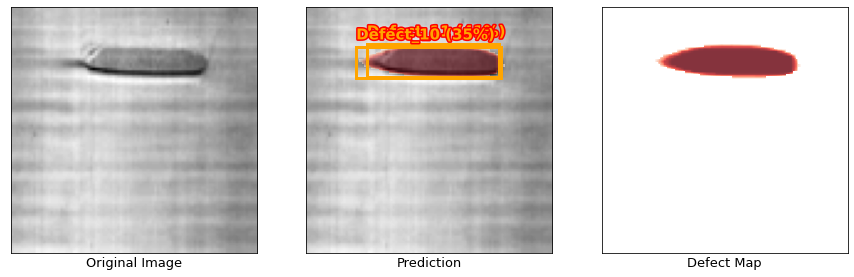

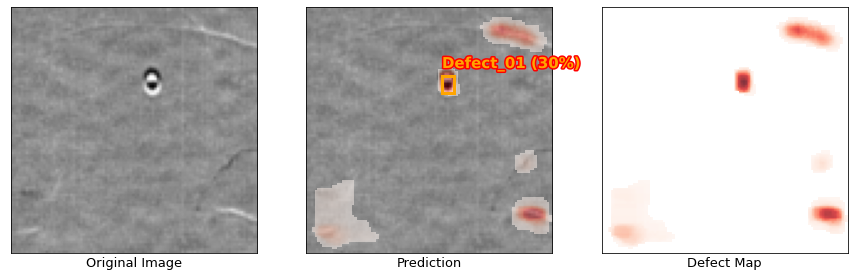

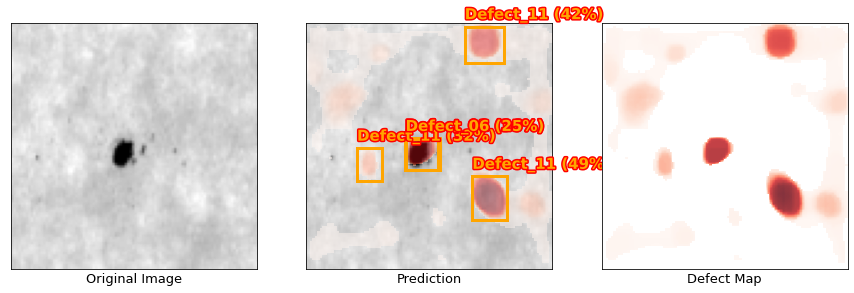

In [4]:
files  = np.sort(glob('sample/*.jpg'))
batchs = get_batch_file_list(files, batch_size=1)

for n, batch in enumerate(batchs):
    tta_images, tta_preds = batch_prediction_tta(mask_model, clf_model, batch, 
                                                 input_img_size  = CFG.TRAIN.IMG_SIZE, 
                                                 output_img_size = CFG.TEST.IMG_SIZE, 
                                                 ts              = get_ts(CFG.TEST.TTA_NUM), 
                                                 iou_thr         = CFG.TEST.IOU_THR,
                                                 skip_box_thr    = CFG.TEST.SKIP_BOX_THR, 
                                                 device          = CFG.TEST.DEVICE)
    plot_graph(tta_images, tta_preds, index=0, thr=0.25, figsize=(15, 10))